In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/honey-bee-pollen/PollenDataset/Read-skimage.ipynb
/kaggle/input/honey-bee-pollen/PollenDataset/Read.ipynb
/kaggle/input/honey-bee-pollen/PollenDataset/README.md
/kaggle/input/honey-bee-pollen/PollenDataset/pollen_data.csv
/kaggle/input/honey-bee-pollen/PollenDataset/images/NP1245-13r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/P27927-213r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/NP16051-251r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/P23667-117r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/NP52583-27r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/NP27452-204r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/NP5576-69r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/P65810-250r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/P61949-194r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/P19386-29r.jpg
/kaggle/input/honey-bee-pollen/PollenDataset/images/NP19958-40r.jpg
/kaggle/input/hon

In [51]:
import glob
import os
import numpy as np
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from keras import layers, models, optimizers

**LOAD DATASETS**

In [52]:
# Load the CSV file containing labels
labels_df = pd.read_csv("../input/honey-bee-pollen/PollenDataset/pollen_data.csv")

# Get the file paths for the images
image_paths = glob.glob("../input/honey-bee-pollen/PollenDataset/images/*.jpg")

In [53]:
# Initialize lists to store image data and labels
images = []
labels = []

In [54]:
labels_df

,Unnamed: 0,filename,pollen_carrying
0,0,P10057-125r.jpg,1
1,1,P57380-120r.jpg,1
2,2,NP63671-221r.jpg,0
3,3,NP53776-47r.jpg,0
4,4,NP13382-201r.jpg,0
...,...,...,...
709,709,NP64239-233r.jpg,0
710,710,NP10304-132r.jpg,0
711,711,NP28671-238r.jpg,0
712,712,P14163-218r.jpg,1


**DROP UNNECESSARY COLUMNS**

In [55]:
labels_df.drop(columns="Unnamed: 0")

,filename,pollen_carrying
0,P10057-125r.jpg,1
1,P57380-120r.jpg,1
2,NP63671-221r.jpg,0
3,NP53776-47r.jpg,0
4,NP13382-201r.jpg,0
...,...,...
709,NP64239-233r.jpg,0
710,NP10304-132r.jpg,0
711,NP28671-238r.jpg,0
712,P14163-218r.jpg,1


**MAP IMAGES WITH LABELS**

In [56]:
# Load images and labels
for image_path in image_paths:
    image = io.imread(image_path)
    image = transform.resize(image, (300, 180), mode='constant')  # Resize image to (300, 180)
    images.append(image)
    image_name = os.path.basename(image_path)
    # Find corresponding label in the CSV file
    label_row = labels_df[labels_df['filename'] == image_name]
    if len(label_row) == 1:  # Ensure there is exactly one matching row
        label = label_row['pollen_carrying'].values[0]  # Get label from CSV
        labels.append(label)
    else:
        print(f"Warning: Missing or duplicate label entry for image {image_name}")

In [57]:
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

**FLATTEN AND PCA**

In [58]:
# Perform PCA
# Flatten the images
n_samples, height, width, channels = images.shape
images_flattened = images.reshape((n_samples, height * width * channels))

# Specify the percentage of variance to retain
variance_to_retain = 0.95  # retain 95% of the variance

# Create PCA object with variance explained as the criterion
pca = PCA(n_components=variance_to_retain)
images_pca = pca.fit_transform(images_flattened)


# Get the number of features (components) before PCA
num_components_before_pca = images_flattened.shape[1]
print("Number of components before PCA:", num_components_before_pca)



Number of components before PCA: 162000


In [59]:
# Get the number of components after PCA transformation
num_components = pca.n_components_
print("Number of components after PCA transformation:", num_components)

Number of components after PCA transformation: 272


**PLOT FIGURE**

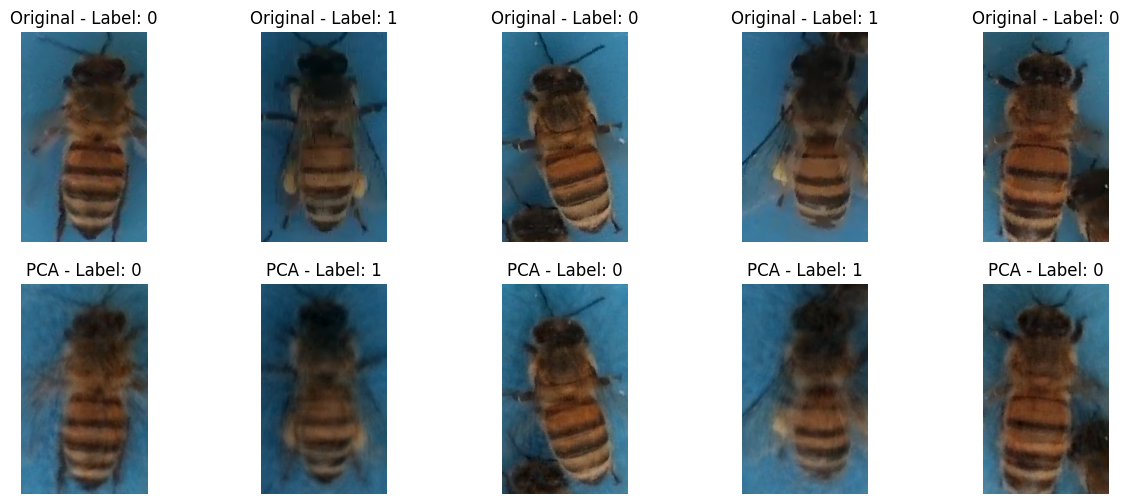

In [60]:
# Display some original images
plt.figure(figsize=(15, 6))
for i in range(5):
    # Original Image
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title("Original - Label: " + str(labels[i]))
    plt.axis('off')

    # PCA Image
    pca_image = pca.inverse_transform(images_pca[i]).reshape(300, 180, 3)
    plt.subplot(2, 5, i + 6)
    plt.imshow(pca_image)
    plt.title("PCA - Label: " + str(labels[i]))
    plt.axis('off')

plt.show()


**MODEL WITHOUT PCA**

In [61]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42)


In [62]:
from keras import Input

# Define the CNN model
model = models.Sequential([
    Input(shape=(300, 180, 3)),  # Input shape for the images
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 298, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 149, 89, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 147, 87, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 73, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 71, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 35, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 33, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 9, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
    # Compile the model
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [72]:
import time

# Train the model without PCA and measure the time taken
start_time = time.time()
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
end_time = time.time()
training_time_without_pca = end_time - start_time

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9391 - loss: 0.1249 - val_accuracy: 0.9100 - val_loss: 0.1847
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9587 - loss: 0.0978 - val_accuracy: 0.9200 - val_loss: 0.1683
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9749 - loss: 0.0817 - val_accuracy: 0.9300 - val_loss: 0.1921
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9732 - loss: 0.0901 - val_accuracy: 0.9200 - val_loss: 0.1449
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9792 - loss: 0.0612 - val_accuracy: 0.9300 - val_loss: 0.1797
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9933 - loss: 0.0249 - val_accuracy: 0.9200 - val_loss: 0.2889
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9861 - loss: 0.0280 - val_accuracy: 0.9200 - val_loss: 0.2195
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9995 - loss: 0.0070 - val_accuracy: 0.9200 - val_loss:

In [74]:
    # Evaluate the model
    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Test accuracy:', test_acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 535ms/step - accuracy: 0.9312 - loss: 0.3100
Test accuracy: 0.9162790775299072


**MODEL WITH PCA**

In [75]:
# Split data into training and testing sets for PCA images
x_train_pca, x_test_pca, y_train_pca, y_test_pca = train_test_split(images_pca, labels, test_size=0.3, random_state=42)


In [76]:
# Define the CNN model for PCA images
model_pca = models.Sequential([
    Input(shape=(num_components,)),  # Input shape corresponds to the number of PCA components
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


# Display model summary
model_pca.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │       139,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,289 (548.00 KB)

 Trainable params: 140,289 (548.00 KB)

 Non-trainable params: 0 (0.00 B)

In [77]:

# Compile the model
model_pca.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [78]:
# Train the model with PCA and measure the time taken
start_time = time.time()
history_pca = model_pca.fit(x_train_pca, y_train_pca, epochs=10, batch_size=32, validation_split=0.2)
end_time = time.time()
training_time_with_pca = end_time - start_time

Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6116 - loss: 0.7732 - val_accuracy: 0.7800 - val_loss: 0.3724
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9577 - loss: 0.1832 - val_accuracy: 0.8500 - val_loss: 0.3576
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9897 - loss: 0.0729 - val_accuracy: 0.8500 - val_loss: 0.3439
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0343 - val_accuracy: 0.8700 - val_loss: 0.3296
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0200 - val_accuracy: 0.8700 - val_loss: 0.3277
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0182 - val_accuracy: 0.8700 - val_loss: 0.3307
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0138 - val_accuracy: 0.8700 - val_loss: 0.3284
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0121 - val_accuracy: 0.8700 - val_loss

In [79]:
# Evaluate the PCA model
test_loss_pca, test_acc_pca = model_pca.evaluate(x_test_pca, y_test_pca)
print('Test accuracy (PCA model):', test_acc_pca)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8573 - loss: 0.3704 
Test accuracy (PCA model): 0.8418604731559753


**TIME COMPARISON**

In [80]:
# Display the comparison
print("Training time without PCA:", training_time_without_pca, "seconds")
print("Training time with PCA:", training_time_with_pca, "seconds")

Training time without PCA: 347.8785936832428 seconds
Training time with PCA: 2.5275919437408447 seconds
